<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO">

# Walmart : predict weekly sales

Walmart Inc. est une multinationale américaine de vente au détail qui exploite une chaîne d’hypermarchés, de grands magasins à rabais et d’épiceries des États-Unis, dont le siège social est situé à Bentonville, en  Arkansas. La société a été fondée par Sam Walton en 1962.

**Projet**  
  
Le service marketing de Walmart vous a demandé de construire un modèle d’apprentissage automatique capable d’estimer les ventes hebdomadaires dans leurs magasins, avec la meilleure précision possible sur les prédictions faites. Un tel modèle les aiderait à mieux comprendre comment les ventes sont influencées par les indicateurs économiques et pourrait être utilisé pour planifier de futures campagnes de marketing.

**Objectifs**  
1) Faire un EDA
2) Entraîner un modèle de régression linéaire  
3) éviter un over-fitting

## Importation des librairies

In [33]:
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score , r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression , Ridge, Lasso
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe"

## 1) EDA

In [2]:
df = pd.read_csv('Walmart_Store_sales.csv') # Importation du csv

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [4]:
# Infortations sur le dataset

print('Voici le shape du dataset : {}'.format(df.shape))
print()

display(df.info())
print()

print('Desciption du dataset :')
display(df.describe())
print()

print('Voici le pourcentage de valeurs nulls pour chaque variable')
display(df.isnull().mean())

Voici le shape du dataset : (150, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


None


Desciption du dataset :


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000



Voici le pourcentage de valeurs nulls pour chaque variable


Store           0.000000
Date            0.120000
Weekly_Sales    0.093333
Holiday_Flag    0.080000
Temperature     0.120000
Fuel_Price      0.093333
CPI             0.080000
Unemployment    0.100000
dtype: float64

**Première information**  
La colonne chômage (Unemployment) est compris entre 5 et 7. Ce sont des données peu cohérentes. On a un manque d'information (faut-il multiplier par 100 ? 1000?...)  


In [5]:
def date(df):
    """ 
    Création d'une colonne "month" et "week" à partir de la colonne "date"
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[:,'Month'] = df['Date'].dt.month
    df.loc[:,'Week'] = df['Date'].dt.week
    
    return df

In [6]:
df = date(df)

<ipython-input-5-3287b59c068f>:7: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



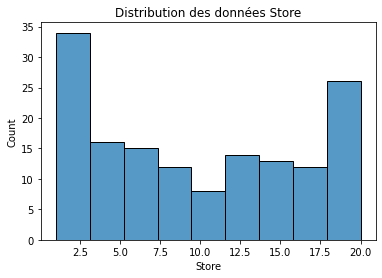

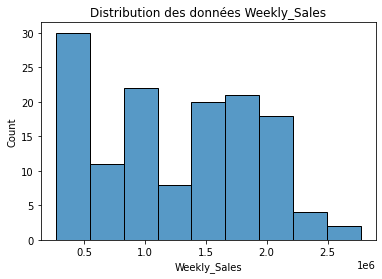

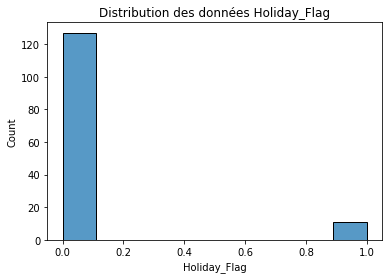

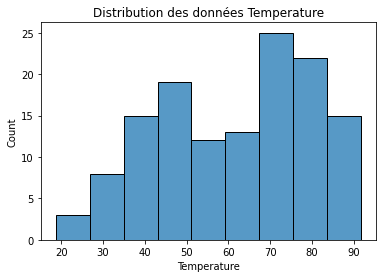

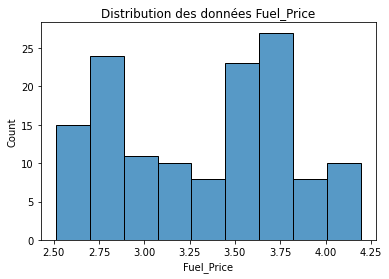

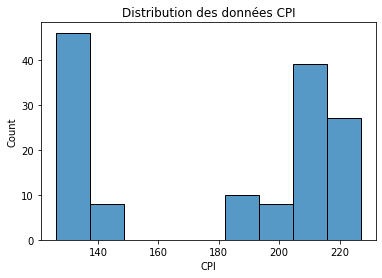

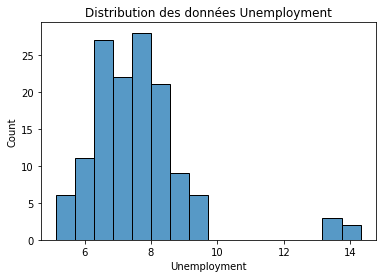

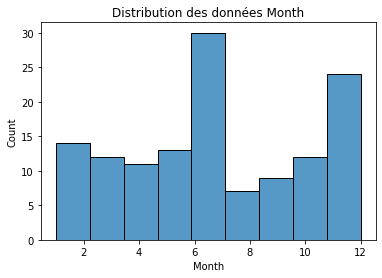

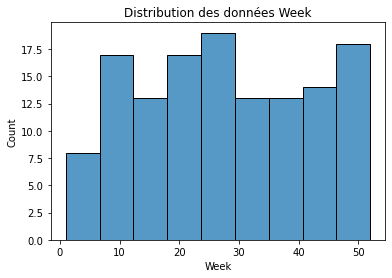

In [7]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.histplot(df[col])
    plt.title('Distribution des données {}'.format(col))

La distribution des données ne suivent pas une loi normale

In [8]:
def imputation(df):
    """
    Suppression des lignes où il y a des valeurs null dans la colonne target(Weekly_Sales)
    Suppression de la colonne Date
    
    traitement des données ! On ne garde pas les valeurs qui sont à +3 ecart type
    pour les features ('Temperature', 'Fuel_Price', 'CPI', 'Unemployment')
    
    
    """
    data = df.dropna(subset = ['Weekly_Sales'])
    data = data.drop('Date', axis = 1)
    
    colonnes = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    
    
    for col in colonnes:
        to_keep = data[col] < data[col].mean() + 3 * data[col].std()
        data = data.loc[to_keep]
        
    return data

In [9]:
data = imputation(df)
data.shape

(90, 9)

On a créé une nouvelle colonne mois et semaine. Ce sont des informations qui pourront être utiles et importantes dans l'entraînement du modèle

Nous avons très peu de valeurs.. Ceci aura des conséquences sur la performance du modèle de machine learning

In [10]:
print('Voici le pourcentage de valeurs nulls pour chaque variable de Data')
display(data.isna().mean())

Voici le pourcentage de valeurs nulls pour chaque variable de Data


Store           0.000000
Weekly_Sales    0.000000
Holiday_Flag    0.111111
Temperature     0.000000
Fuel_Price      0.000000
CPI             0.000000
Unemployment    0.000000
Month           0.111111
Week            0.111111
dtype: float64

# Visualisation 

In [11]:
month = data.groupby('Month')['Weekly_Sales'].sum().sort_values().reset_index()

px.bar(month, x = 'Month', y ='Weekly_Sales', color = 'Weekly_Sales', title="Ventes moyennes selon le mois de l'année" )

**Interprétations**  
Le mois où la vente est la plus importante est :  Mars, Décembre (Noël)  
Les mois où les ventes sont les plus basses sont : Janvier, Septembre et Novembre

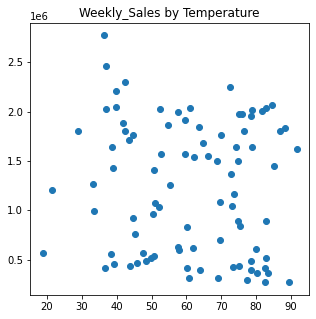

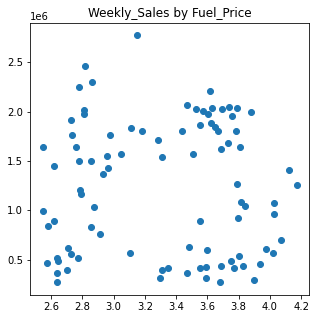

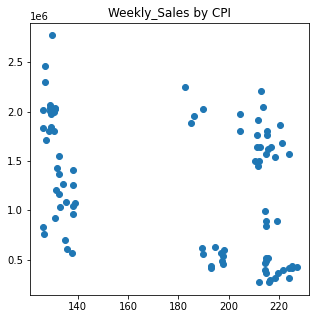

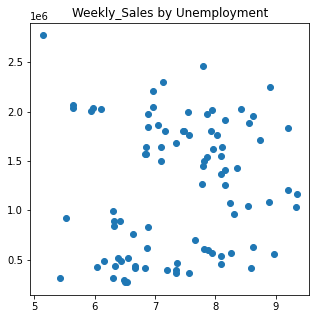

In [12]:
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for f in features:
    plt.subplots(figsize= (5,5))
    plt.scatter(data[f], data['Weekly_Sales'])
    plt.title('Weekly_Sales by {}'.format(f))
    plt.show()
    
    

Les graphiques ci-dessus, permettent d'avoir une première idée de la corrélation entre les features et la target.  
Ici le résultat montre qu'il n'y a pas de corrélation linéaire marquante entre les features et la target

# 2) Régression Linéaire

**Preprocessing**  
Dans cette partie:  
- Séparer les données en deux. Un partie sera les données d'entraînement, le deuxième sera la partie de test.  
- Preprocessing. Il y a des données numériques et catégorielles. 

Nous avons des variables numériques et des variables catégorielles.  
Variables numériques : Temperature, Fuel_Price, CPI, Unemployment, Month, Week  
Variables catégorielles : Store, Holiday_Flag  
  
Pour entraîner le modèle, il faut faire un préprocessing des variables.  
**Pour les variables numériques :**  
Les features Month et Week présentent dans valeurs nulles ! J'ai choisi de les remplacer par la valeur median. Je standarise l'ensemble des données avec un StandardScaler.  
**Pour les variables catégorielles :**  
La feature Holiday_Flag présente également des valeurs nulles ! J'ai choisi des les remplacer par la valeur la plus représentée (most_frequent). Le OneHotEncoder va permettre de créer et ajouter des colonnes (dummies) binaires qui réfèrent ou non la donnée par un 0 ou 1.

In [13]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=0)

In [15]:
def num_cat(numeric_features = [], categorical_features = []):
    """
    Création d'un pipeline pour le préprocessing des features numériques
    
    Création d'un pipeline pour le préprocessing des features catégorielles
    
    IN : numeric_features --> Position des colonnes numériques dans X_train/X_test
         categorical_features --> Position des colonnes catégorielle dans X_train/X_test
         
    OUT: On assemble les deux pipelines pour faire un pipeline preprocessor
    """
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop = 'first'))
    ])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
    
    return preprocessor

In [16]:
def preprocessing(data_train, data_test, numeric_features = [], categorical_features = []):
    """
    IN : data_train --> dataset train
         data_test --> dataset test
         numeric_features --> Position des colonnes numériques dans X_train/X_test
         categorical_features --> Position des colonnes catégorielle dans X_train/X_test
         
    OUT : X_train, y_train, X_test, y_test
    
    Dans cette fonction, on récupère les datasets d'entrainement et de test. On sépare les features de la target. 
    On trasforme en numpy array.
    On appliplique le preprocessor de la fonction num_cat
    
    """
    n = numeric_features
    c = categorical_features
    
    X_train = data_train.drop(['Weekly_Sales'], axis = 1) 
    y_train = data_train['Weekly_Sales']
    
    X_test = data_test.drop(['Weekly_Sales'], axis = 1) 
    y_test = data_test['Weekly_Sales']
    
    X_train = X_train.values
    y_train = y_train.values
    X_test = X_test.values
    y_test = y_test.values
    
    preprocessor = num_cat(n,c)
    
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, y_train, X_test, y_test

In [17]:
X_train, y_train, X_test, y_test = preprocessing(trainset, testset, numeric_features = [2, 3 , 4 , 5, 6,7],  categorical_features = [0,1])

# Application du modèle 

In [47]:
def evaluation(model, X_train, X_test, y_train, y_test):
   
    model.fit(X_train, y_train)
    
    ypred_test = model.predict(X_test)
    ypred_train = model.predict(X_train)
    

    
    return ypred_train, ypred_test, r2_score(y_train, ypred_train),r2_score(y_test, ypred_test)

In [44]:
model = LinearRegression() # modèle de régression linéaire

In [48]:
ypred_train, ypred_test, Rscore_train, Rscore_test = evaluation(model,X_train, X_test, y_train, y_test)

print("Accuracy on training set:", Rscore_train)
print("Accuracy on test set:", Rscore_test)

Accuracy on training set: 0.9851464406071564
Accuracy on test set: 0.9264432900113063


In [34]:
model.coef_

array([-1.91493893e+02, -6.76251316e+04,  7.73314912e+05,  2.80480614e+04,
        4.81793198e+05, -4.66084355e+05,  2.52494641e+05, -1.26154202e+06,
        2.34052650e+06, -1.23086512e+06,  9.89948806e+04, -5.59758410e+05,
       -6.82079645e+05, -1.10759634e+06,  1.89496657e+06,  2.33239077e+05,
        2.23635080e+06,  1.08072927e+06,  7.16597434e+05, -5.28438034e+05,
        1.03740908e+06,  1.07610293e+06,  1.48611584e+06,  6.06440533e+05,
       -7.87760897e+04])

**Résultats**  
On obtient un modèe avec de bonnes performances. Un R2 proche de 1 pour les données d'entraînements. Le R2(test) < R2(train) de 0.6. Il est possible de diminuer cette différence et de diminuer l'over fitting.

Il y a beaucoup de coef, c'est normal !! On a réalisé un OneHotEncodor ce qui à multiplié le nbr de variables

# Ridge / Lasso

**Ridge et Lasso** sont deux modèles très utiles et très utilisés pour la régression linéaire. Différent l'un de l'autre, les deux modèles ont un même objectif : Pénaliser les coefficients. Minimiser la fonction coût c'est minimiser les coefficients de la régression.

**Ridge** : On introduit un biais dans le modèle pour un meilleur compromis. Une  augmentation du biais entraînera une baisse de la variance dans un modèle de sur-ajustement et nous aidera à long terme.  
    En régression linéaire, la régression Ridge pénalise la somme des carrés des résidus + lambda * la pente² .  Lambda c'est l'ampleur de la pénalité. Plus le lambda est élevé, plus le modèle sera régularisé mais plus fort sera le biais

In [35]:
#GridSearchCV pour trouver les meilleurs paramètres 

params = {'alpha' : [0,10, 100, 200]}
ridge = Ridge()
gridRidge = GridSearchCV(ridge, param_grid=params, cv=5, verbose=1)

gridRidge.fit(X_train, y_train)

gridRidge.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'alpha': 0}

In [36]:
print("BEST ESTIMATOR:")
best_model_Ridge1 = gridRidge.best_estimator_
print("      train R2:",
      best_model_Ridge1.score(X_train, y_train))
print("      test R2:",
      best_model_Ridge1.score(X_test, y_test))

rtrain_1 = best_model_Ridge1.score(X_train, y_train)
rtest_1 = best_model_Ridge1.score(X_test, y_test)



BEST ESTIMATOR:
      train R2: 0.9835432888422062
      test R2: 0.9265995261888874


**Résultat**  
On obtient toujours un model avec de bonnes performances. On remarque que la différence entre le R2_train et le R2_test est toujours de 0.6.

# Lasso

**Lasso :** Semblable à la régression Ridge, la régression Lasso permet également de régulariser un modèle. Lasso prendra une équation similaire mais prendra la valeur absolue de la pente plutôt que la quadrature. Il prendra la somme des carrés des résidus + lambda * la valeur absolue de la pente. Dans Lasso, au lieu de simplement pénaliser les fonctionnalités les moins importantes lors de l'utilisation de Ridge, Lasso peut réduire les fonctionnalités pour n'avoir aucun impact sur le modèle final. 

In [37]:
lasso = Lasso()

In [38]:
params = {'alpha' : [0, 50, 100, 200, 400, 800]}
gridLasso = GridSearchCV(lasso, param_grid=params, cv=5, verbose=1)

gridLasso.fit(X_train, y_train)

gridLasso.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\marti\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 176189323561.08167, tolerance: 2488243055.832358

C:\Users\marti\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 172603882307.3275, tolerance: 2425932262.9849753

C:\Users\marti\anaconda3\lib\site-packages\sklearn\model_selection\_

{'alpha': 0}

In [39]:
print("BEST ESTIMATOR:")
best_model_Lasso = gridLasso.best_estimator_
print("      train R2:",
      best_model_Lasso.score(X_train, y_train))
print("      test R2:",
      best_model_Lasso.score(X_test, y_test))

ltrain = best_model_Lasso.score(X_train, y_train)
ltest = best_model_Lasso.score(X_test, y_test)


BEST ESTIMATOR:
      train R2: 0.9848708655338275
      test R2: 0.9277680464224508


# Conclusion 

1) Exploration des données :  
    * Très peu de données (90 lignes) après preprocessing
    * Manque d'information sur les données du chômage

2) Modèle de regression linéaire
    * R2_train = 0.98 
    * modèle performant
    * léger over-fitting

3) Over-fitting
    * Utilisation de Ridge et Lasso. Les résultats obtenus montrent que les deux modèles n'ont pas permis une réduction de l'over-fitting. Je pense qu'il faut augmenter le nombre de données.

In [49]:
result = pd.DataFrame({"LinearRegression 1" : (r2_score(y_train, ypred_train) , r2_score(y_test, ypred_test)),
                      "Ridge" : (rtrain_1 , rtest_1),
                      "Lasso" : (ltrain, ltest)},
                     index = ("R2 train", "R2 test"))

result

,LinearRegression 1,Ridge,Lasso
R2 train,0.985146,0.983543,0.984871
R2 test,0.926443,0.926600,0.927768


**Perspectives :**  
Regarder l'influence de certaines variables sur le modèle. Certaines features n'ont peut être aucunes influence sur la prédiction.  
Utilisation du time-series pour une meilleure prédiction ? 